# Generic Imports and Config

In [1]:
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import glob

import os
from scipy.io import wavfile
import librosa
import librosa.display

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Playing some song and noisy song

Song


Noisy song


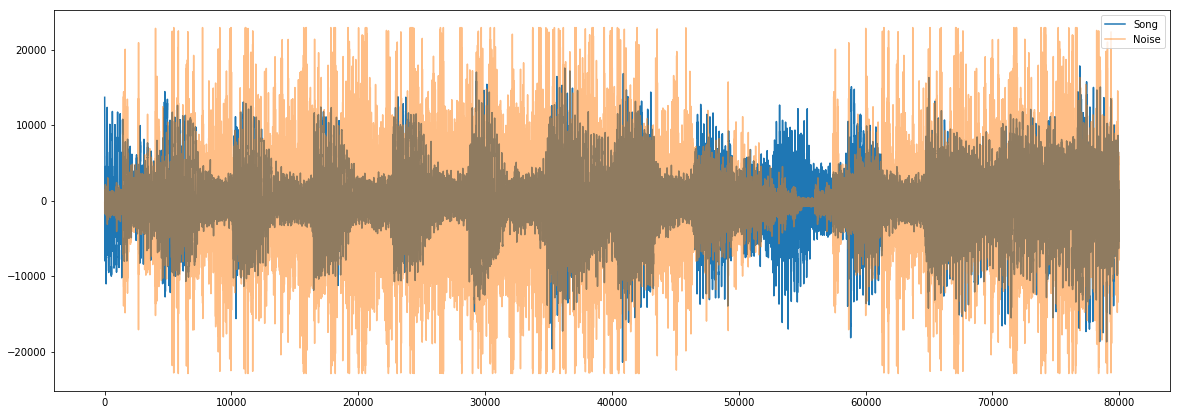

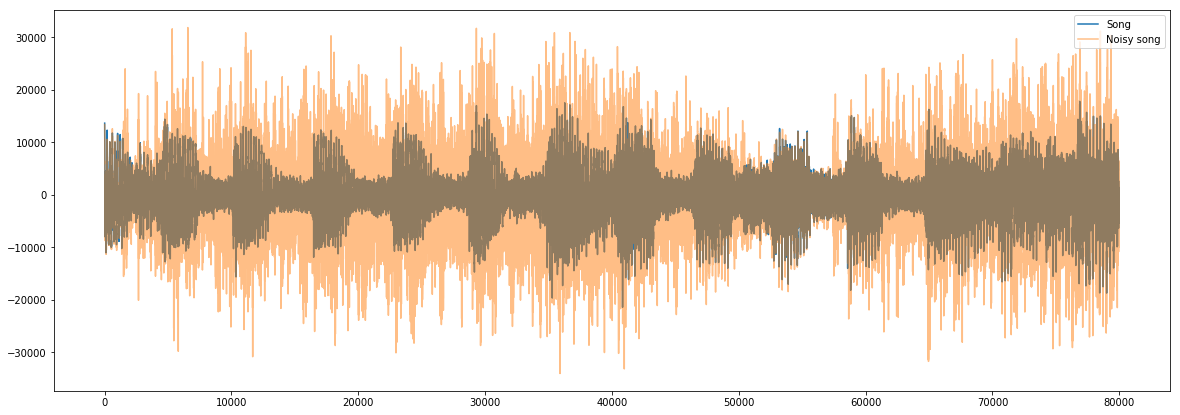

In [5]:
print("Song")
display(Audio(song, rate=sr))
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(song, label="Song");
ax.plot(noise, label="Noise", alpha=0.5);
plt.legend(loc="upper right");

print("Noisy song")
display(Audio(noisy_song, rate=sr))
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(song, label="Song");
ax.plot(noisy_song, label="Noisy song", alpha = 0.5);
plt.legend(loc="upper right");

# Test1: Changing song phase with noisy song phase 

In [6]:
# config
preprocess.VORBIS_WINDOW = preprocess.vorbis_window(preprocess.WINDOW_LEN)
print("window_len", preprocess.WINDOW_LEN)
print("window_ms", preprocess.WINDOW_MS)
print("step", preprocess.STEP)

window_len 480
window_ms 30
step 240


Song with Noisy song phase


Song


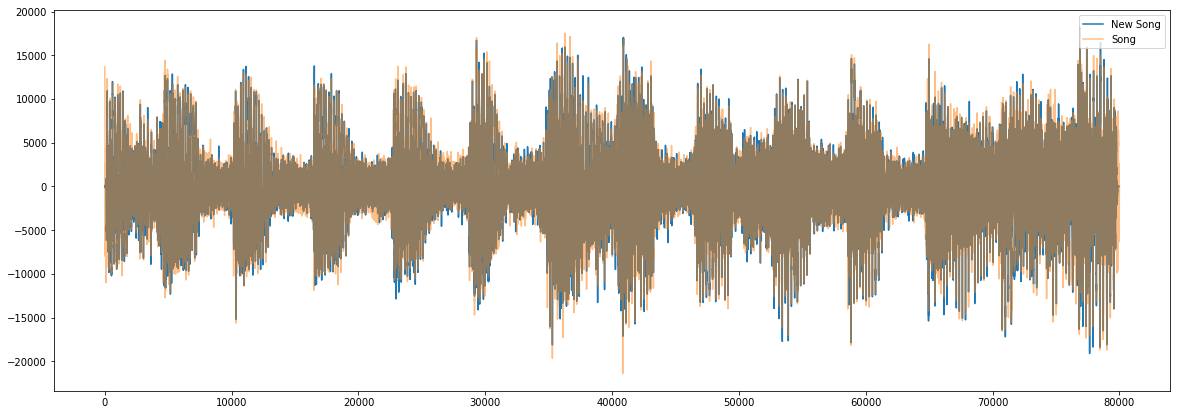

In [7]:
new_song = np.zeros(len(song))
frame_count = len(song) // preprocess.STEP - 1

for i in range(frame_count):
    noisy_cur_window = noisy_song[i * preprocess.STEP: i * preprocess.STEP + preprocess.WINDOW_LEN]
    noisy_magn, noisy_phase = preprocess.get_magn_phase(noisy_cur_window)

    song_cur_window = song[i * preprocess.STEP: i * preprocess.STEP + preprocess.WINDOW_LEN]
    song_magn, song_phase = preprocess.get_magn_phase(song_cur_window)

    song_new_fft = song_magn * noisy_phase
    song_new_window = np.fft.irfft(song_new_fft) * preprocess.VORBIS_WINDOW
    new_song[i * preprocess.STEP: i * preprocess.STEP + preprocess.WINDOW_LEN] += song_new_window

print("Song with Noisy song phase")
display(Audio(new_song, rate=sr))
print("Song")
display(Audio(song, rate=sr))

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(new_song, label="New Song");
ax.plot(song, label="Song", alpha=0.5);
plt.legend(loc="upper right");  

# Test2: Ratio Masks

**Apply Ratio Mask Filtering (Oracle)**

Spectrograms are images ! We cannot reconstruct easily song from them, because we miss the phase information.

However, if we have the spectrogram of song and noisy song, we may use the noisy song and its phase to get good estimate for the song.
That's what called `oracle filtering` in the jargon. 

Let's separate the songs this way.
We apply a *mask* to the noisy_song, which is a matrix of [0-1] numbers. This mask called a *ratio mask*

In [8]:
song_fft_magn = []
noisy_song_fft_magn = []
noisy_song_fft_phase = []
noise_fft_magn = []
frame_count = len(song) // preprocess.STEP - 1

for i in range(frame_count):
    # song
    song_cur_window = song[i * preprocess.STEP: i * preprocess.STEP + preprocess.WINDOW_LEN]
    song_magnitude, song_phase = preprocess.get_magn_phase(song_cur_window)
    song_fft_magn.append(song_magnitude)
    # noisy song
    noisy_cur_window = noisy_song[i * preprocess.STEP: i * preprocess.STEP + preprocess.WINDOW_LEN]
    noisy_magnitude, noisy_phase = preprocess.get_magn_phase(noisy_cur_window)
    noisy_song_fft_magn.append(noisy_magnitude)
    noisy_song_fft_phase.append(noisy_phase)
    # noise
    noise_cur_window = noise[i * preprocess.STEP: i * preprocess.STEP + preprocess.WINDOW_LEN]
    noise_magn, noise_phase = preprocess.get_magn_phase(noise_cur_window)
    noise_fft_magn.append(noise_magn)

# making np array
song_fft_magn = np.array(song_fft_magn)
noisy_song_fft_magn = np.array(noisy_song_fft_magn)
noisy_song_fft_phase = np.array(noisy_song_fft_phase)
noise_fft_magn = np.array(noise_fft_magn)

### Ratio Mask with formula     $Mask_{song}=\frac{S_{song}}{S_{noisy\_song}}$   

$Mask_{IBM}=\frac{S_{song}}{S_{noisy\_song}}$

mask shape (332, 241)


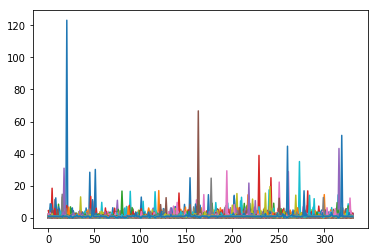

In [9]:
mask_1 = song_fft_magn / (noisy_song_fft_magn + 1e-7)
print("mask shape", mask_1.shape)
plt.plot(mask_1);

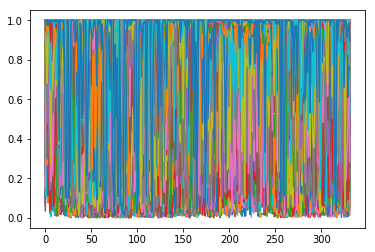

In [10]:
# clip mask to have [0, 1] values
mask_1 = np.clip(mask_1, 0, 1)
plt.plot(mask_1);

In [11]:
# estimate song fft magnitude with the mask
estimated_magn_1 = mask_1 * noisy_song_fft_magn

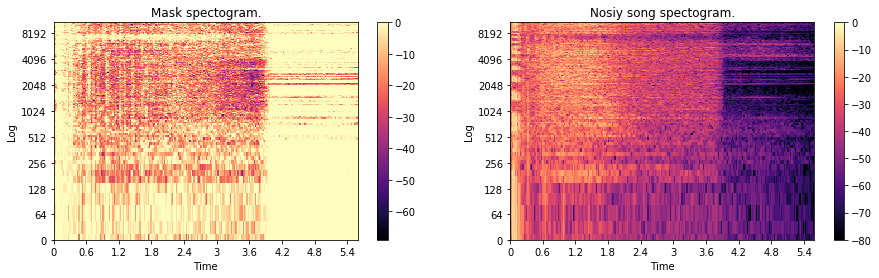

In [12]:
plt.figure(figsize=(15, 4));
plt.subplot(1, 2, 1);
librosa.display.specshow(librosa.amplitude_to_db(mask_1, ref=np.max), y_axis='log', x_axis='time')
plt.ylabel('Log');
plt.colorbar();
plt.title('Mask spectogram.');

plt.subplot(1, 2, 2);
librosa.display.specshow(librosa.amplitude_to_db(noisy_song_fft_magn, ref=np.max), y_axis='log', x_axis='time')
plt.ylabel('Log');
plt.colorbar();
plt.title('Nosiy song spectogram.');

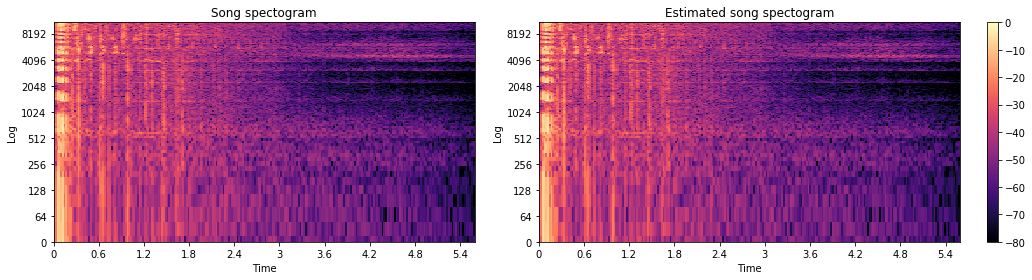

In [13]:
plt.figure(figsize=(15, 4));
plt.subplot(1, 2, 1);
librosa.display.specshow(librosa.amplitude_to_db(song_fft_magn, ref=np.max), y_axis='log', x_axis='time');
plt.ylabel('Log');
plt.colorbar();
plt.title('Song spectogram');
plt.tight_layout();

plt.subplot(1, 2, 2);
librosa.display.specshow(librosa.amplitude_to_db(estimated_magn_1, ref=np.max), y_axis='log', x_axis='time');
plt.ylabel('Log');
plt.colorbar();
plt.title('Estimated song spectogram');
plt.tight_layout();

### Ratio Mask with formula     $Mask_{song}=\sqrt\frac{S_{song}^2}{S_{song}^2+S_{noise}^2}$

**Deriving formula for mask**



$Mask_{song}=\frac{S_{song}}{S_{noisy\_song}} = \sqrt\frac{S_{song}^2}{(S_{song}+S_{noise})^2} = \sqrt\frac{S_{song}^2}{S_{song}^2+2S_{song}S_{noise} + S_{noise}^2} \approx \sqrt\frac{S_{song}^2}{S_{song}^2+S_{noise}^2}$

mask shape (332, 241)


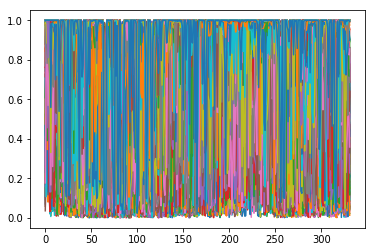

In [14]:
# mask ratio
mask_2 = np.sqrt(np.square(song_fft_magn) / (np.square(song_fft_magn) + np.square(noise_fft_magn) + 1e-7))
print("mask shape", mask_2.shape)
plt.plot(mask_2);

**Attention**! 
Here no need to clip data [0, 1].

In [15]:
# estimate song fft magnitude with the mask
estimated_magn_2 = mask_2 * noisy_song_fft_magn

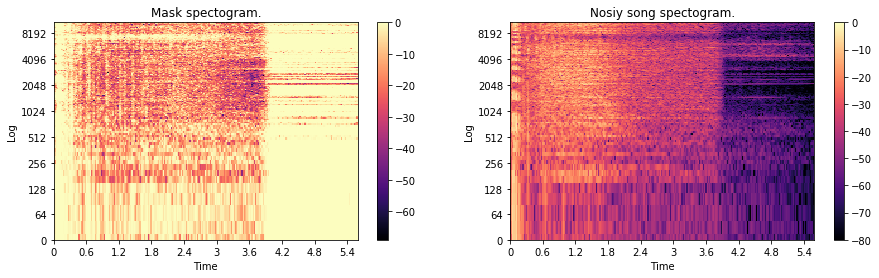

In [16]:
plt.figure(figsize=(15, 4));
plt.subplot(1, 2, 1);
librosa.display.specshow(librosa.amplitude_to_db(mask_2, ref=np.max), y_axis='log', x_axis='time')
plt.ylabel('Log');
plt.colorbar();
plt.title('Mask spectogram.');

plt.subplot(1, 2, 2);
librosa.display.specshow(librosa.amplitude_to_db(noisy_song_fft_magn, ref=np.max), y_axis='log', x_axis='time')
plt.ylabel('Log');
plt.colorbar();
plt.title('Nosiy song spectogram.');

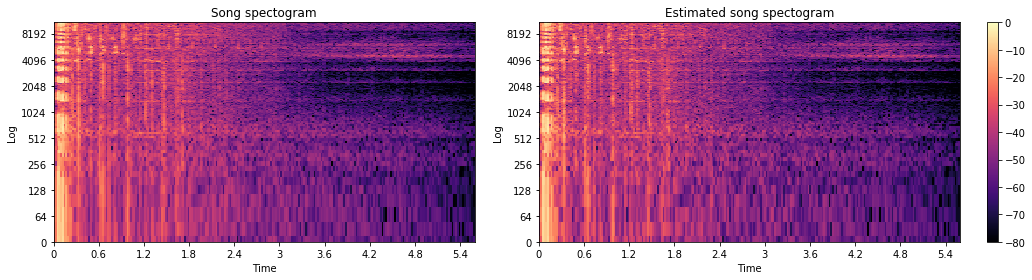

In [17]:
plt.figure(figsize=(15, 4));
plt.subplot(1, 2, 1);
librosa.display.specshow(librosa.amplitude_to_db(song_fft_magn, ref=np.max), y_axis='log', x_axis='time');
plt.ylabel('Log');
plt.colorbar();
plt.title('Song spectogram');
plt.tight_layout();

plt.subplot(1, 2, 2);
librosa.display.specshow(librosa.amplitude_to_db(estimated_magn_2, ref=np.max), y_axis='log', x_axis='time');
plt.ylabel('Log');
plt.colorbar();
plt.title('Estimated song spectogram');
plt.tight_layout();

### Estimating song with ratio masks

In [18]:
def get_song_from_fft(estimated_magn):
  estimated_song = np.zeros(len(song))
  frame_count = len(song) // preprocess.STEP - 1

  for i in range(frame_count):
      cur_phase = noisy_song_fft_phase[i]
      cur_magn = estimated_magn[i]

      cur_fft = cur_magn * cur_phase
      cur_window = np.fft.irfft(cur_fft) * preprocess.VORBIS_WINDOW
      estimated_song[i * preprocess.STEP: i * preprocess.STEP + preprocess.WINDOW_LEN] += cur_window

  return np.array(estimated_song)

In [21]:
# get songs
estimated_song_1 = get_song_from_fft(estimated_magn_1)
estimated_song_2 = get_song_from_fft(estimated_magn_2)

wavfile.write('./results/RNN/estim_1.wav', sr, estimated_song_1.astype("int16"))

####With ratio mask $Mask_{song}=\frac{S_{song}}{S_{noisy\_song}}$

Estimated song


Original song


Noisy song


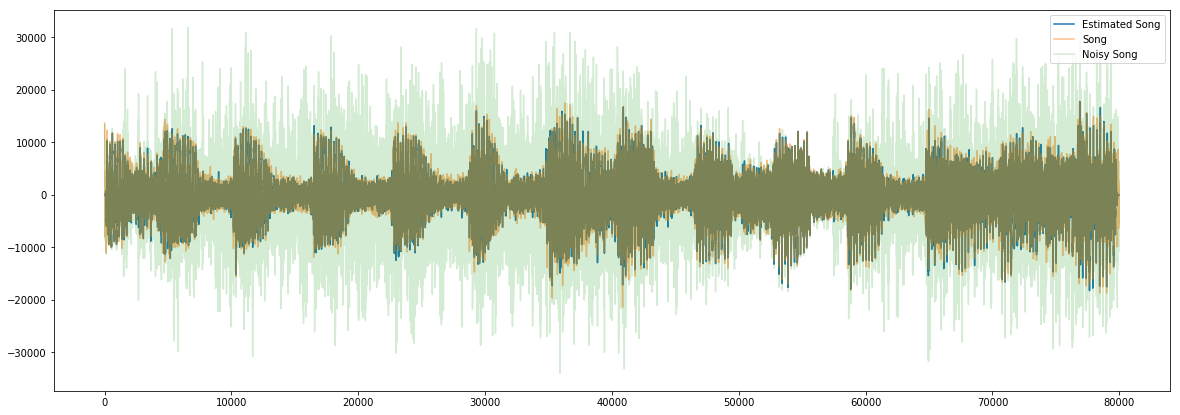

In [20]:
print("Estimated song")
display(Audio(estimated_song_1, rate=sr))
print("Original song")
display(Audio(song, rate=sr))
print("Noisy song")
display(Audio(noisy_song, rate=sr))

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(estimated_song_1, label="Estimated Song");
ax.plot(song, label="Song", alpha=0.5);
ax.plot(noisy_song, label="Noisy Song", alpha=0.2);
plt.legend(loc="upper right");  

####With ratio mask $Mask_{song}=\sqrt\frac{S_{song}^2}{S_{song}^2+S_{noise}^2}$

Estimated song


Original song


Noisy song


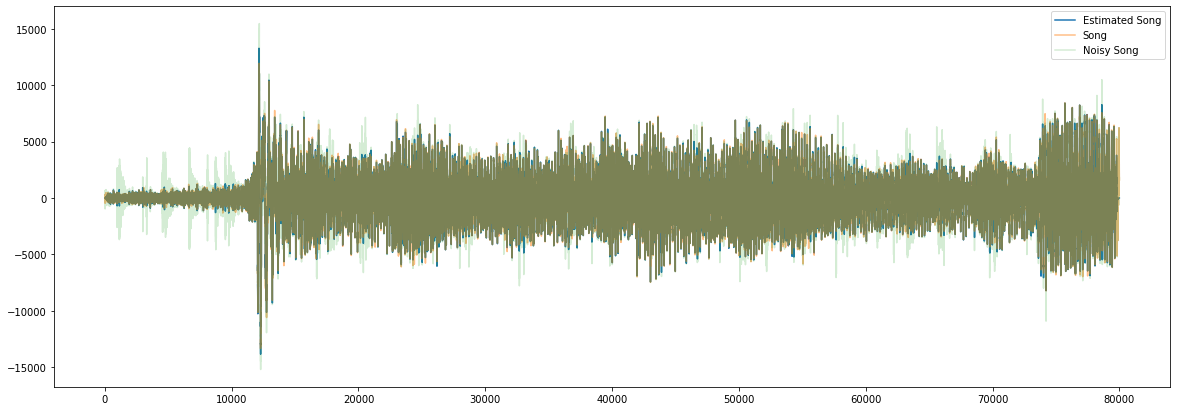

In [161]:
print("Estimated song")
display(Audio(estimated_song_2, rate=sr))
print("Original song")
display(Audio(song, rate=sr))
print("Noisy song")
display(Audio(noisy_song, rate=sr))

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(estimated_song_2, label="Estimated Song");
ax.plot(song, label="Song", alpha=0.5);
ax.plot(noisy_song, label="Noisy Song", alpha=0.2);
plt.legend(loc="upper right");  

####Comparing two ratio masks

Estimated 1


Estimated 2


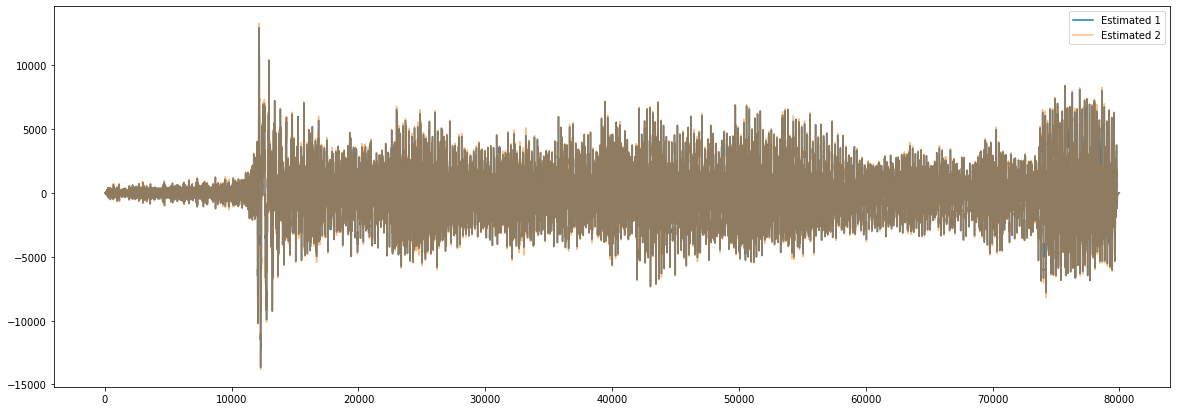

In [165]:
print("Estimated 1")
display(Audio(estimated_song_1, rate=sr))
print("Estimated 2")
display(Audio(estimated_song_2, rate=sr))


fig, ax = plt.subplots(figsize=(20,7))
ax.plot(estimated_song_1, label="Estimated 1");
ax.plot(estimated_song_2, label="Estimated 2", alpha=0.5);
plt.legend(loc="upper right");  

In [2]:
def vorbis_window(N):
    return np.sin((np.pi / 2) * (np.sin(np.pi * np.arange(N) / N)) ** 2)

In [3]:
# paths
mix_path = "../data/Songs/test_song/Alexander Ross - Velvet Curtain/mixture16_noisy_song_diff_claps.wav"
song_path = "../data/Songs/test_song/Alexander Ross - Velvet Curtain/mixture16.wav"
# config
real_sr = 16000
big_window_len = real_sr * 5
big_step = int(big_window_len / 2)
small_window_len = int(real_sr * 30 / 1000)
small_step = int(small_window_len / 2)
small_frames_count = int(big_window_len / small_step) - 1
# read
sr_mix, mix = wavfile.read(mix_path) 
sr_song, song = wavfile.read(song_path)
# check
assert sr_mix == real_sr
assert sr_song == real_sr
assert len(mix) == len(song)

song = song.astype('float32')
mix = mix.astype('float32')

big_frames_count = len(mix) // big_step - 1
small_vorbis_window = vorbis_window(small_window_len)
big_vorbis_window_squared = vorbis_window(big_window_len) ** 2

In [6]:
new_song = np.zeros(len(mix))
for i in range(big_frames_count):
    cur_mix_big_frame = mix[i * big_step: i * big_step + big_window_len]
    cur_song_big_frame = song[i * big_step: i * big_step + big_window_len]
    assert len(cur_mix_big_frame) == big_window_len
    assert len(cur_song_big_frame) == big_window_len
    new_big_window = np.zeros(big_window_len)
    for j in range(small_frames_count):
        cur_mix_small_frame = cur_mix_big_frame[j * small_step: j * small_step + small_window_len]
        cur_song_small_frame = cur_song_big_frame[j * small_step: j * small_step + small_window_len]
        cur_mix_ft = np.fft.rfft(cur_mix_small_frame * small_vorbis_window)
        cur_song_ft = np.fft.rfft(cur_song_small_frame * small_vorbis_window)
        
        #abs
#         cur_ratio_mask = np.abs(cur_song_ft)**2/(np.abs(cur_mix_ft-cur_song_ft) +  np.abs(cur_song_ft))**2
        
        #divide
#         cur_ratio_mask = np.abs(cur_song_ft)/ (np.abs(cur_mix_ft) + 1e-7)
#         cur_ratio_mask_appl = np.abs(cur_mix_ft - cur_song_ft) / (np.abs(cur_mix_ft)+ 1e-7)

        #sum square
#         cur_ratio_mask = np.sqrt(np.abs(cur_song_ft)**2/(np.abs(cur_mix_ft-cur_song_ft)**2 +  np.abs(cur_song_ft)**2))
#         cur_ratio_mask_appl = np.abs(cur_mix_ft-cur_song_ft)**2/(np.abs(cur_mix_ft-cur_song_ft)**2 +  np.abs(cur_song_ft)**2)

        #clip
        cur_ratio_mask = np.clip(np.abs(cur_song_ft)/ (np.abs(cur_mix_ft) + 1e-7), 0, 1)
#         cur_ratio_mask_appl = np.clip(np.abs(cur_mix_ft - cur_song_ft) / (np.abs(cur_mix_ft)+ 1e-7), 0, 5)

        new_cur_song_ft = cur_ratio_mask * cur_mix_ft
#         new_cur_song_ft = cur_mix_ft - cur_ratio_mask_appl * cur_mix_ft

        new_song_small_frame = np.fft.irfft(new_cur_song_ft) * small_vorbis_window
        new_big_window[j * small_step: j * small_step + small_window_len] += new_song_small_frame
    new_song[i * big_step: i * big_step + big_window_len] += new_big_window * big_vorbis_window_squared
    
# handle clipping
max_absolute_new_song = np.max(np.abs(new_song))
if max_absolute_new_song > 32767:
    new_song = new_song * (32767 / max_absolute_new_song)
            
wavfile.write("./ipnb_check_diff_claps/with_vorbis.wav", real_sr, new_song.astype("int16"))